# Laboratorio 3 - Parte 1 

### Modelos de mezclas de funciones Gausianas y k-means

### 2019-II

#### Profesor: Julián D. Arias Londoño
#### julian.ariasl@udea.edu.co


## Guía del laboratorio

En este archivo va a encontrar tanto celdas de código cómo celdas de texto con las instrucciones para desarrollar el laboratorio.

Lea atentamente las instrucciones entregadas en las celdas de texto correspondientes y proceda con la solución de las preguntas planteadas.

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

#### Primer integrante: Kevin Martínez Gallego
#### Segundo integrante: Andrés Álvarez Ortiz

In [1]:
#Algunas advertencias que queremos evitar
import warnings
warnings.filterwarnings("always") 

%matplotlib inline
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import numpy.matlib as matlib
from scipy import stats

## Ejercicio 1: Contextualización del problema

A continuación se leen los datos de un problema de clasificación. El problema corresponde a la clasificación de dígitos escritos a mano. Usaremos únicamente 4 de las 10 clases disponibles. Los datos fueron preprocesados para reducir el número de características. La técnica usada será analizada más adelante en el curso.

In [2]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
digits = load_digits(n_class=4)

#--------- preprocesamiento--------------------
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)

#---------- Datos a usar ----------------------
X = data
Y = digits.target

Un vistazo a la base de datos

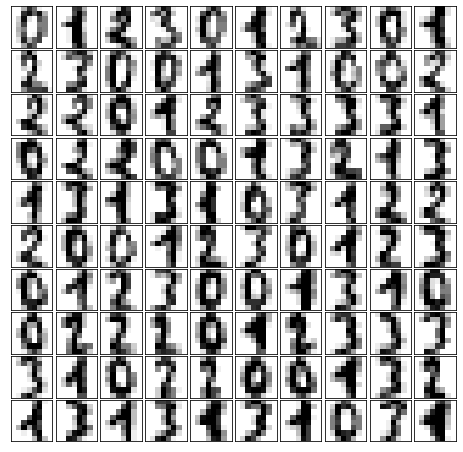

In [3]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

In [4]:
print(X.shape)
print(Y.shape)
print(np.unique(Y, return_counts = True))

(720, 39)
(720,)
(array([0, 1, 2, 3]), array([178, 182, 177, 183]))


Responda:

1.1 ¿Cuántas muestras por clase tiene la base de datos?:

La base de datos tiene 4 clases. 
La clase correspondiente al digito 0 tiene 178 muestras;
la clase correspondiente al digito 1 tiene 182 muestras;
la clase correspondiente al digito 2 tiene 177 muestras;
la clase correspondiente al digito 3 tiene 183 muestras.

1.2 ¿Cuántas características tiene cada muestra?


Cada muestra tiene 39 características.

1.2 Teniendo en cuenta el tipo de problema y el número de muestras por clase, ¿qué metodología de validación debería usar?¿Porqué?:

Como hay un número equilibrado de muestras por clase, el problema no esta desbalanceado, por lo cual se podría usar tranquilamente la validación cruzada o la validación booststrap. Sin embargo, sería ideal utilizar validación cruzada leave-one-out debido a que no contamos con muchos datos, y deberíamos proporcionarle al sistema tantas muestras como sea posible para el entrenamiento.
Adicionalmente, es recomendable combinar la metodología seleccionada con la validación estratificada, así evitaríamos que al partir el conjunto de muestras se desbalanceen las particiones.

## Ejercicio 2: Completar el código

En la siguiente celda defina una función que tome como entradas una matriz $X$ y una matriz $Y$, entrene un modelo GMM  (Modelo de mezclas gaussianas) por cada clase y retorne el listado de modelos para cada clase. Debe consultar todo lo relacionado con la creación, entrenamiento y uso en predicción de este modelo usando la librería scikit-learn. Consultar aquí: http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html


Adicionalmente construya una función que use los modelos entrenados en la función anterior para hacer la clasificación de un conjunto nuevo de muestras.



In [5]:
from sklearn.mixture import GaussianMixture

def GMMClassifierTrain(X,Y,M,tipo):
    
    #X: Matriz con las características
    #Y: Matriz con las clases
    #M: Número de componentes
    #tipo: Tipo de matriz de covarianza
    
    tipoCov = 'full'
    if(tipo == 'diagonal'):
        tipoCov = 'diag'
    elif(tipo == 'esferica'):
        tipoCov = 'spherical'
    elif(tipo == 'atada'):
        tipoCov = 'tied'
    
    clases = np.unique(Y)
    GMMs = []
    
    for i in range(np.size(clases)): # iteramos por cada clase
        muestrasClase = X[Y==i,:] # todas las muestras pertenecientes a la clase
        modeloClase = GaussianMixture(n_components=M, covariance_type=tipoCov, max_iter=100, init_params='kmeans')
        modeloClase.fit(muestrasClase) # Estimate model parameters with the EM algorithm.
        GMMs.append(modeloClase)
        
    return GMMs #Debe retornar un objeto que contenga todos los modelos entrenados


def GMMClassfierVal(GMMs,Xtest):
    clases = len(GMMs)
    muestras = np.size(Xtest, 0)
    Yest = np.zeros(muestras)
    probabilidades = np.zeros((muestras, clases))
    
    for i in range(clases): # iteramos por cada clase
        probabilidades[:,i] = np.exp(GMMs[i].score_samples(Xtest)) 
        # Calculamos las probabilidadades de las muestras en la clase i.
        # score_samples: Compute the weighted log probabilities for each sample.
        # utilizamos la exponencial para obtener el valor de probabilidad dado por la función logaritmica
        
    Yest = np.argmax(probabilidades, axis=1) # obtenemos la mayor probabilidad (índice) para cada muestra 
    
    return Yest #Debe retornar un vector con las clases predichas para cada una de las muestras en Xtest, de acuerdo con los modelos almacenados en GMMs

## Ejercicio 3: Entrenamiento

En la siguiente celda se define una simulación para entrenar y validar un modelo usando los datos previamente cargados de lo digitos. Complete el código para usar como modelo de predicción un GMM.

Asegure que:


                                - Matriz de covarianza: diagonal 
                                - Numero de componentes: 3
                                - Eficiencia en validacion: 0.9555	
                                - Intervalo de confianza: 0.02297


In [6]:
import math
import numpy as np
from numpy import random
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

#Validamos el modelo
def mainGMM(num_components, cov_type):
    Folds = 4
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:]
        Ytrain = Y[train]
        Xtest = X[test,:]
        Ytest = Y[test]

        #Normalizamos los datos
        media = np.mean(Xtrain)
        desvia = np.std(Xtrain)
        Xtrain = sc.stats.stats.zscore(Xtrain)
        Xtest = (Xtest - np.matlib.repmat(media, Xtest.shape[0], 1))/np.matlib.repmat(desvia, Xtest.shape[0], 1)

        #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
        #(X,Y,M,tipo)

        gmms = GMMClassifierTrain(Xtrain,Ytrain,num_components,cov_type)

        #Validación
        Ytrain_pred = GMMClassfierVal(gmms,Xtrain);
        Yest = GMMClassfierVal(gmms,Xtest);

        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(Ytrain_pred.ravel() == Ytrain.ravel())
        EficienciaVal[j] = np.mean(Yest.ravel() == Ytest.ravel())
        j += 1
        
    print('Eficiencia durante el entrenamiento = ' + str(np.mean(EficienciaTrain)) + '+-' + str(np.std(EficienciaTrain)))
    print('Eficiencia durante la validación = ' + str(np.mean(EficienciaVal)) + '+-' + str(np.std(EficienciaVal)))
    return (np.mean(EficienciaVal),np.std(EficienciaVal))

   

In [21]:
mainGMM(3, 'diagonal')

Eficiencia durante el entrenamiento = 0.9986093773577142+-0.001540159626776286
Eficiencia durante la validación = 0.9555068542222571+-0.022967890779648337


(0.9555068542222571, 0.022967890779648337)

## Ejercicio 4: Resultados

Una vez completado el código realice los experimentos necesarios para llenar la siguiente tabla:

In [7]:
import pandas as pd
import qgrid
randn = np.random.randn
df_types = pd.DataFrame({
    'Matriz de covarianza' : pd.Series(['Completa','Completa','Completa','Completa','Completa','Completa','Diagonal','Diagonal','Diagonal','Diagonal','Diagonal','Diagonal','Esférica','Esférica','Esférica','Esférica','Esférica','Esférica','Atada','Atada','Atada','Atada','Atada','Atada']),
    'Numero de componentes' : pd.Series([1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6])})
df_types["Eficiencia en validacion"] = ""
df_types["Intervalo de confianza"] = ""
df_types.set_index(['Matriz de covarianza','Numero de componentes'], inplace=True)
#df_types["Eficiencia en validacion"][8] = "0.9555"
#df_types["Intervalo de confianza"][8] = "0.02297"
#df_types.sort_index(inplace=True)

matricesCov = ['completa', 'diagonal', 'esferica', 'atada']
numeroComponentes = 6
indice = 0
for i in range(len(matricesCov)):
    tipo = matricesCov[i]
    for j in range(numeroComponentes):
        eficiencia, std = mainGMM(j+1, tipo)
        df_types["Eficiencia en validacion"][indice] = eficiencia
        df_types["Intervalo de confianza"][indice] = std
        indice+=1

qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget

/opt/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:282: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/qgrid/grid.py:573: DeprecationWarning: metadata {'sync': True} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  _df_json = Unicode('', sync=True)


Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.9834479272694958+-0.014043974572147429
Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.9681536008332576+-0.013022908857458793
Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.912416908045111+-0.029747965775809456
Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.6899249310119687+-0.12103174952956765
Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.5173994995516398+-0.09648566591263898
Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.4084583510698063+-0.028087280561425322
Eficiencia durante el entrenamiento = 0.9874913312685584+-0.004034179257013327
Eficiencia durante la validación = 0.9263682245912502+-0.010018017854166889
Eficiencia durante el entrenamiento = 0.9953677586353733+-0.0009388043015629532
Eficiencia durante la validaci

/opt/anaconda3/lib/python3.7/site-packages/qgrid/grid.py:827: DeprecationWarning: QgridWidget._df_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _df_changed(self):


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Ejecute la siguiente instrucción para dejar guardados en el notebook los resultados de las pruebas.


In [8]:
qgrid_widget.get_changed_df()

Eficiencia en validacion  \
Matriz de covarianza Numero de componentes                            
Completa             1                                     0.983448   
                     2                                     0.968154   
                     3                                     0.912417   
                     4                                     0.689925   
                     5                                     0.517399   
                     6                                     0.408458   
Diagonal             1                                     0.926368   
                     2                                     0.937496   
                     3                                     0.955507   
                     4                                     0.938831   
                     5                                     0.947181   
                     6                                     0.959727   
Esférica             1                                     0.883324   
                     2                                     0.855615   
                     3                                     0.882075   
                     4                                     0.848669   
                     5                                     0.866695   
                     6                                     0.870924   
Atada                1                                     0.983448   
                     2                                     0.984822   
                     3                                     0.983448   
                     4                                     0.982043   
                     5                                     0.983448   
                     6                                     0.987584   

                                           Intervalo de confianza  
Matriz de covarianza Numero de componentes                         
Completa             1                                   0.014044  
                     2                                  0.0130229  
                     3                                   0.029748  
                     4                                   0.121032  
                     5                                  0.0964857  
                     6                                  0.0280873  
Diagonal             1                                   0.010018  
                     2                                  0.0106219  
                     3                                  0.0229679  
                     4                                  0.0238506  
                     5                                  0.0284322  
                     6                                  0.0159021  
Esférica             1                                  0.0187698  
                     2                                  0.0267366  
                     3                                  0.0233614  
                     4                                  0.0118516  
                     5                                 0.00612685  
                     6                                  0.0267725  
Atada                1                                   0.014044  
                     2                                  0.0131489  
                     3                                   0.014044  
                     4                                  0.0125162  
                     5                                   0.014044  
                     6                                 0.00982343

Responda

4.1 La tabla incluye un tipo de matriz de covarianza no visto en clase, Atada, ¿En qué consiste este tipo de matriz según la documentación en scikit-learn?:

Scikit-learn: "all components share the same general covariance matrix."
Todos los componentes de una misma clase comparten la misma matriz de covarianza general (una matriz completa).

4.2  ¿Qué método se utilizó para la incialización de los parámetros del modelo GMM?:

Scikit-learn permite inicializar los parámetros del modelo GMM de dos maneras diferentes: utilizando el método k-means o de manera aleatoria (a través del parámetro de la función init_params). En este caso usamos la estrategia k-means, ya que esta inicializa las medias en puntos distantes para producir mejores resultados.

4.3 ¿El algoritmo EM presentó problemas de convergencia o colapso para alguna de las combinaciones de parámetros?

En este caso no se presentaron problemas de convergencia o colapso. No obstante, esto puede ocurrir si con alguna combinación se genera una matriz de covarianza nula, lo que implicaría que esta no fuese invertible y la función gaussiana de ese componente quedaría indeterminada.

## Ejercicio 5

En la siguiente celda, utilice las muestras de la base de datos iris incluidos en la variable Xclustering. 
Lleve a cabo el agrupamiento de los datos usando el algoritmo k-means y el modelo GMM.

Consultar todo lo relacionado al llamado del método KMeans de la librería scikit-learn en el siguiente enlace: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html. 


Realice el agrupamiento para 2 y 3 grupos y grafique los resultados del agrupamiento en cada caso (use colores para los puntos de acuerdo con el grupo asignado por el algoritmo de agrupamiento). Para el caso del GMM use una matriz de covarianza completa y una matriz diagonal. El resultado de este punto son 6 gráficas.

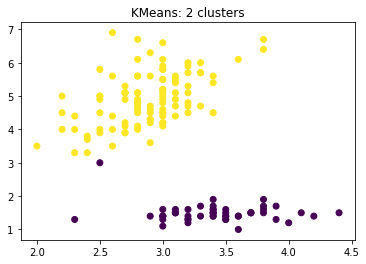

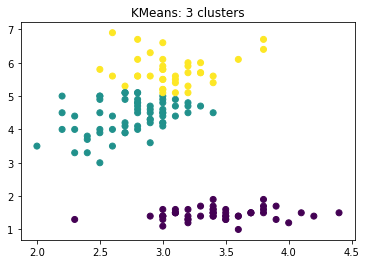

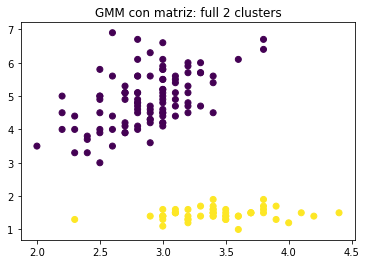

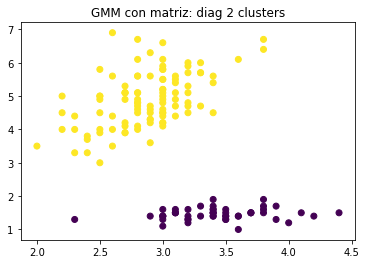

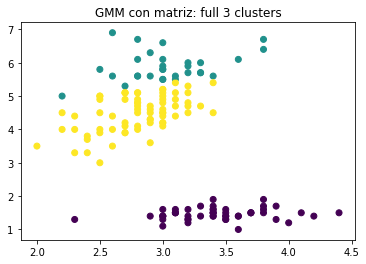

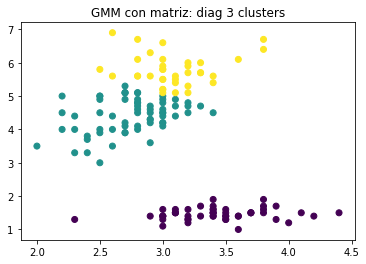

In [14]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

data = load_iris()
X=data.data
Xclustering = X[:,1:3]
vector = [2,3]
matriz = ['full', 'diag']
for i in range (np.size(vector)):
    modelo = KMeans(init='k-means++', n_clusters=vector[i], n_init=1)
    modelo.fit(Xclustering)
    Y = modelo.predict(Xclustering)
    plt.scatter(Xclustering[:,0], Xclustering[:,1], c = Y)
    plt.title('KMeans: '+ str(vector[i]) + ' clusters')
    plt.show() 
for i in range (np.size(vector)):
    for j in range (np.size(matriz)):
        modelo = GaussianMixture(n_components = vector[i], covariance_type = matriz[j])
        modelo.fit(Xclustering)
        Y = modelo.predict(Xclustering)
        plt.scatter(Xclustering[:,0], Xclustering[:,1], c = Y)
        plt.title('GMM con matriz: '+ matriz[j]+' '+ str(vector[i]) + ' clusters')
        plt.show() 